# Pruebas con Albumentations

In [277]:
import pickle
with open("data.pkl","rb") as f:
    (df_train, df_val, train_files_names, val_files_names, classes_idx, cant_classes, classes) = pickle.load(f)

In [278]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [279]:
import albumentations as A
from PIL import Image
import matplotlib.patches as patches

In [280]:
with open("anchor_boxes.pkl", "rb") as f:
    anchor_boxes = pickle.load(f)
cant_anchor_boxes = len(anchor_boxes)
print(cant_anchor_boxes)

4


In [281]:
transform = A.Compose([
    A.RandomCrop(width=300, height=300),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
], bbox_params=A.BboxParams(format='coco', min_area=300, min_visibility=0.1, label_fields=["class_labels"]))

In [282]:
df_train.loc[0].head()

,label,left,top,right,bottom,height,width,image,image_name,center_x,center_y,delta_x,delta_y
0,pineapple,38.0,82.0,271.0,227.0,300.0,400.0,dataset\images\fruit0.png,fruit0.png,154.5,154.5,233.0,145.0
0,pineapple,38.0,87.0,275.0,241.0,300.0,400.0,dataset\images\fruit1.png,fruit1.png,156.5,164.0,237.0,154.0
0,pineapple,37.0,47.0,225.0,165.0,300.0,400.0,dataset\images\fruit100.png,fruit100.png,131.0,106.0,188.0,118.0
0,pineapple,38.0,64.0,223.0,175.0,300.0,400.0,dataset\images\fruit101.png,fruit101.png,130.5,119.5,185.0,111.0
0,pineapple,50.0,86.0,222.0,190.0,300.0,400.0,dataset\images\fruit103.png,fruit103.png,136.0,138.0,172.0,104.0


In [283]:
train_files_names

array(['fruit0.png', 'fruit1.png', 'fruit100.png', 'fruit101.png',
       'fruit103.png', 'fruit104.png', 'fruit105.png', 'fruit106.png',
       'fruit108.png', 'fruit109.png', 'fruit11.png', 'fruit110.png',
       'fruit111.png', 'fruit112.png', 'fruit113.png', 'fruit114.png',
       'fruit117.png', 'fruit118.png', 'fruit119.png', 'fruit12.png',
       'fruit120.png', 'fruit121.png', 'fruit122.png', 'fruit123.png',
       'fruit124.png', 'fruit125.png', 'fruit126.png', 'fruit127.png',
       'fruit128.png', 'fruit129.png', 'fruit13.png', 'fruit130.png',
       'fruit131.png', 'fruit132.png', 'fruit133.png', 'fruit134.png',
       'fruit135.png', 'fruit136.png', 'fruit137.png', 'fruit138.png',
       'fruit139.png', 'fruit14.png', 'fruit140.png', 'fruit141.png',
       'fruit142.png', 'fruit143.png', 'fruit144.png', 'fruit146.png',
       'fruit147.png', 'fruit149.png', 'fruit15.png', 'fruit150.png',
       'fruit152.png', 'fruit153.png', 'fruit154.png', 'fruit156.png',
       'fruit15

In [284]:
img_nbr=10 # 10 anda
image_name = train_files_names[img_nbr]
image_file = df_train[df_train["image_name"] == image_name]["image"]

In [285]:
print(image_name)

fruit11.png


In [286]:
image_name

'fruit11.png'

In [287]:
image_file

0    dataset\images\fruit11.png
1    dataset\images\fruit11.png
2    dataset\images\fruit11.png
Name: image, dtype: object

In [288]:
image = np.array(Image.open(image_file.values[0]))
bboxes = df_train[df_train["image"]==image_file.values[0]][["left","top","delta_x","delta_y"]]

In [289]:
labels = df_train[df_train["image"]==image_file.values[0]]["label"]

In [290]:
print(labels.values)

['pineapple' 'snake fruit' 'dragon fruit']


In [291]:
bboxes

,left,top,delta_x,delta_y
0,86.0,124.0,166.0,100.0
1,213.0,203.0,24.0,26.0
2,200.0,241.0,60.0,58.0


In [292]:
bboxes.values

array([[ 86., 124., 166., 100.],
       [213., 203.,  24.,  26.],
       [200., 241.,  60.,  58.]])

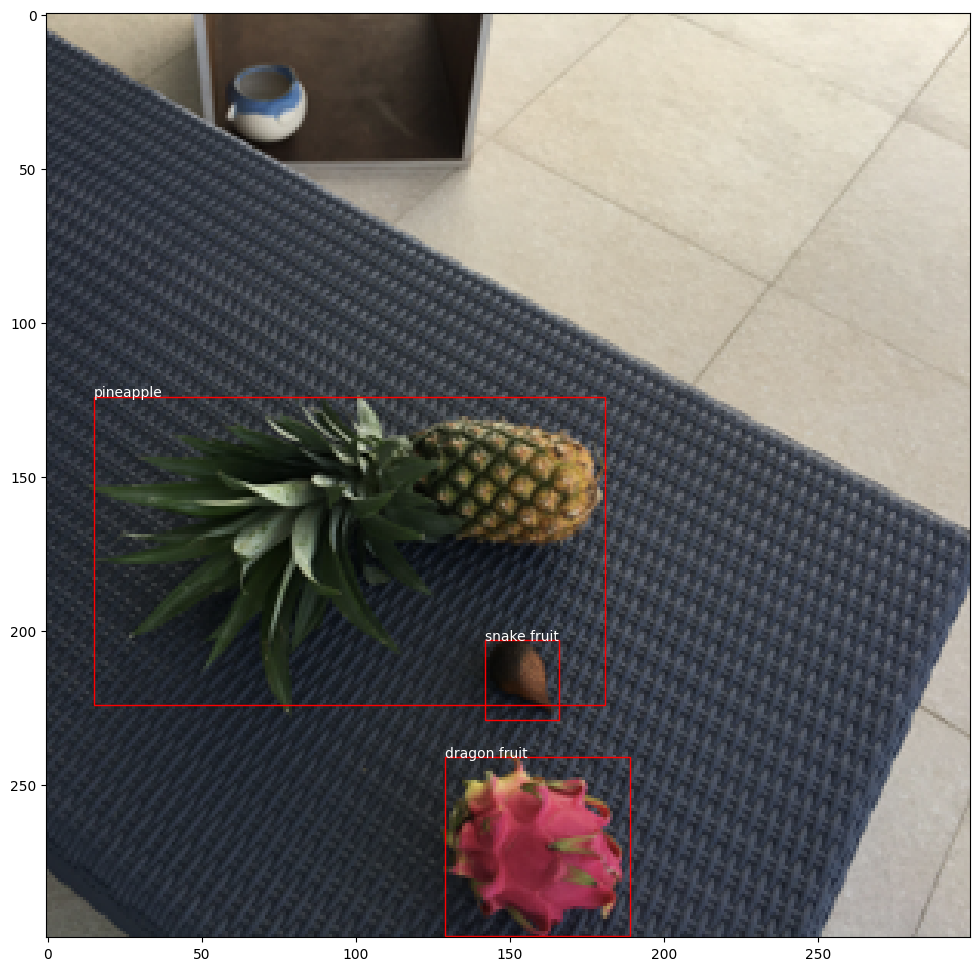

In [293]:
transformed = transform(image=image, bboxes=bboxes.values, class_labels = labels)
# Create figure and axes
fig,ax = plt.subplots(1, figsize=[12,12])
plt.imshow(transformed["image"])
for i in range(len(transformed["bboxes"])):
    bbox = transformed["bboxes"][i]
    rect = patches.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],linewidth=1,edgecolor='r',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
    plt.text(bbox[0], bbox[1], labels[i], c="w")
plt.show()

In [294]:
bboxes_aug = transformed["bboxes"]
image_aug = transformed["image"]

# En qué gridcell anoto cada bbox?

supongamos gridcells de 32x32

Esta celda indica en qué gridcell se encuentra el centro del bounding box.

In [295]:
# Es útil tener una función que reciba los bounding boxes y me devuelva en qué gridcell debo anotar cada uno
def get_gridcell(bboxes_aug, grid_size):
    print( [((bbox[0] + bbox[2]/2), 
             (bbox[1] + bbox[3]/2)) for bbox in bboxes_aug])
    grid_cells = [((bbox[0] + bbox[2]/2)//grid_size[0], 
                   (bbox[1] + bbox[3]/2)//grid_size[1]) for bbox in bboxes_aug]
    return grid_cells

In [296]:
bboxes_aug

array([[ 15.000002, 124.      , 166.      , 100.      ],
       [142.00002 , 203.      ,  23.999977,  25.999992],
       [129.      , 241.      ,  59.999992,  58.      ]], dtype=float32)

Gridcells de 32,32

In [297]:
get_gridcell(bboxes_aug,[32,32])

[(98.00000190734863, 174.0), (154.00000381469727, 215.99999618530273), (158.99999618530273, 270.0)]


[(3.0, 5.0), (4.0, 6.0), (4.0, 8.0)]

In [298]:
# Es exactamente la misma función que antes, pero sin los prints
def get_gridcell(bboxes_aug,grid_size):
    grid_cells = [(int((bbox[0] + bbox[2]/2)//grid_size[0]), 
                   int((bbox[1] + bbox[3]/2)//grid_size[1])) for bbox in bboxes_aug]
    return grid_cells

In [299]:
grid_cells = get_gridcell(bboxes_aug,[32,32]) # grid_cells a los que pertenecen los bounding boxes
grid_cells_u = np.unique(get_gridcell(bboxes_aug,[32,32]), axis=0) #uniques de los grid_cells, esto es por si varios van al mismo gridcell
print(grid_cells)
print(grid_cells_u)

[(3, 5), (4, 6), (4, 8)]
[[3 5]
 [4 6]
 [4 8]]


In [300]:
grid_cells

[(3, 5), (4, 6), (4, 8)]

# Chequeo de IoU con anchor boxes

In [301]:
# Esta función me devuelve el IoU entre un bounding box y cada uno de los anchor boxes para luego decidir en cuáles lo anoto
def anchor_check(anchor_boxes, bbox):
    aux_bbox = np.array(bbox).reshape(-1,4).repeat(len(anchor_boxes),axis=0)
    # Compara ancho_anchor_box vs deltax (minimo) * alto_anchor_box vs deltay (minimo)
    intersects = np.min([anchor_boxes[:,0],aux_bbox[:,2]],axis=0)*np.min([anchor_boxes[:,1],aux_bbox[:,3]],axis=0)
    union = aux_bbox[:,2]*aux_bbox[:,3]+anchor_boxes[:,0]*anchor_boxes[:,1]-intersects
    return intersects/union

In [302]:
# Defino el umbral a partir del cual anoto un bounding box en un anchor box
IoU_alpha = 0.5

img_nbr=10

> por algún motivo, no funciona con img_nbr != img_nbr

In [303]:
annotations = list()
for cell_u in grid_cells_u:
    indexes = [cell_u.tolist() == list(grid_cell) for grid_cell in grid_cells]
    # indexes = los indices de los bounding boxes que estan en una grid_cell
    bboxes_cell = [bboxes_aug[idx] for idx,index in enumerate(indexes) if index]
    # todos los bounding boxes que están en una misma grid_cell
    label = [labels[idx] for idx,index in enumerate(indexes) if index]
    winners = np.zeros([len(bboxes_cell),len(anchor_boxes)])
    for idx,bbox in enumerate(bboxes_cell):
        winners[idx,:] = anchor_check(anchor_boxes,bbox)
    mask = winners.max(axis=0) > IoU_alpha
    bbox_nbr = winners.argmax(axis=0)
    for ab,(m,b) in enumerate(zip(mask,bbox_nbr)):
        if m:
            annotations.append((*cell_u, ab, *bboxes_cell[b], label[b]))

In [304]:
# grid_cell_x, grid_cell_y, anchor_box, min_x, min_y, delta_x, delta_y, clase
annotations

[(3, 5, 1, 15.000002, 124.0, 166.0, 100.0, 'pineapple'),
 (3, 5, 2, 15.000002, 124.0, 166.0, 100.0, 'pineapple'),
 (4, 6, 3, 142.00002, 203.0, 23.999977, 25.999992, 'snake fruit'),
 (4, 8, 0, 129.0, 241.0, 59.999992, 58.0, 'dragon fruit')]

cada annotation de annotation**s** debería tener esta forma:

```
(3,
 11,
 2,
 0.0,
 213.90722300000016,
 229.08000000000004,
 278.06910700000003,
 'Tomato')
 ```

 porque después, en el `for ann in annotations:` no existe el index 7 (la string)

 > No ocurre


In [305]:
print(len(annotations))
print(len(annotations[0]))

4
8


# Conversión del formato de la anotación a YOLO

> Donde dice 300, antes decía 512, el crop original del proyecto.

Por cada anchor box, tenemos 1 salida.

In [306]:
ann_size = 1 + cant_classes + 4 # confidencia + clase + bbox
y = np.zeros([1,int(300/32),int(300/32), len(anchor_boxes)*ann_size]) #reservo espacio para las anotaciones de 1 imagen

In [307]:
y.shape

(1, 9, 9, 36)

De esto: grid_cell_x, grid_cell_y, anchor_box, min_x, min_y, delta_x, delta_y, clase

A esto (YOLO)
[confidencia, clase1, clase2, clase3, clase4, min_x, min_y, delta_x, delta_y]

Por cada anchor_box de cada grid_cell con alguna anotacion

In [308]:
# grid_cell, anchor_box, bbox
for ann in annotations:
    y[0,ann[1],ann[0], ann[2]*ann_size] = 1 # Anoto que hay objeto en este AB (el primer elemento de anchorbox)
    y[0,ann[1],ann[0], ann[2]*ann_size+1+classes_idx[ann[7]]] = 1 # Anoto la clase del objeto (anoto 1 en la clase)
    y[0,ann[1],ann[0], ann[2]*ann_size+1+cant_classes:ann[2]*ann_size+1+cant_classes+4] = ann[3:7]

In [309]:
annotations[1]

(3, 5, 2, 15.000002, 124.0, 166.0, 100.0, 'pineapple')

In [310]:
y[0,8,4].reshape(-1,ann_size)

array([[  1.        ,   0.        ,   0.        ,   1.        ,
          0.        , 129.        , 241.        ,  59.99999237,
         58.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ]])

# No nos sirve el formato del bbox para YOLO, tenemos que referirlo a la celda


center_x,center_y: 0,0 -> borde superior izquierdo de la celda  
x,y: 1,1 -> borde inferior derecho de la celda  
delta_x y delta_y: 1 para indicar un gridcell de ancho, puede ser mayor a 1  

In [311]:
anns = np.array(annotations)
anns = anns[:,:-1].astype(float)
print(anns)

[[  3.         5.         1.        15.000002 124.       166.
  100.      ]
 [  3.         5.         2.        15.000002 124.       166.
  100.      ]
 [  4.         6.         3.       142.00002  203.        23.999977
   25.999992]
 [  4.         8.         0.       129.       241.        59.999992
   58.      ]]


In [312]:
anns[0]

array([  3.      ,   5.      ,   1.      ,  15.000002, 124.      ,
       166.      , 100.      ])

Pone en el centro

In [313]:
anns[:,3] = ((anns[:,3]+anns[:,5]/2)-anns[:,0]*32)/32
anns[:,4] = ((anns[:,4]+anns[:,6]/2)-anns[:,1]*32)/32

In [314]:
anns[0]

array([3.00000000e+00, 5.00000000e+00, 1.00000000e+00, 6.25000625e-02,
       4.37500000e-01, 1.66000000e+02, 1.00000000e+02])

In [315]:
213.9+278.07/2

352.935

In [316]:
anns = np.array(annotations)
anns = anns[:,:-1].astype(float)
anns[:,3:5] = ((anns[:,3:5]+anns[:,5:7]/2)-anns[:,0:2]*32)/32
anns[0]

array([3.00000000e+00, 5.00000000e+00, 1.00000000e+00, 6.25000625e-02,
       4.37500000e-01, 1.66000000e+02, 1.00000000e+02])